# Transform Consistency Loss

In [2]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

A few things to fix:
- Understanding the paper
- Loading the data
- Converting the handedness
- Converting between different extrinsic formats and choosing great names for them
- Understanding the sources of NaN - perspective division and taking a log of a negative number

How I was able to do all of these things in 1/2 a day:
- Writing lots of little tests

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

In [9]:
def load_data_as_memmap(filename, directory):
    directory = pathlib.Path(directory)
    dataset = np.load(filename)
        
    output = {
        'K': dataset['K'],
        'transforms': dataset['transforms'],
    }
    
    # Send the RGB & depth data to a file on disk to avoid OOM
    for key in ('rgbs', 'depths'):
        data = dataset[key]
        filename = directory / f'{key}.npy'
        fp = np.memmap(filename, dtype='float32', mode='w+', shape=data.shape)
        fp[:] = data[:]
        output[key] = np.memmap(filename, dtype='float32', mode='r', shape=data.shape)
        # decrease the size of dataset 
        if output[key].shape[0] > 48:
            continue
    return output

In [10]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_q = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255.
        image_0 = torch.from_numpy(self.rgbs[idx+1].copy()).permute(2, 0, 1) / 255.
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()).permute(2, 0, 1) / 255.

        # Our depth images in CHW format
        depth_q = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_0 = torch.from_numpy(self.depths[idx+1].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z ->-z,-x,-y
        axes = torch.tensor([
            [ 0,-1, 0, 0.],
            [ 0, 0,-1, 0.],
            [-1, 0, 0, 0.],
            [ 0, 0, 0, 1.],
        ]).double()

        # Our poses
        extrinsic_q = axes @ torch.from_numpy(self.transforms[idx+0])
        extrinsic_0 = axes @ torch.from_numpy(self.transforms[idx+1])
        extrinsic_1 = axes @ torch.from_numpy(self.transforms[idx+2])
        
        # Let's compute the relative transforms here
        R_q0 = extrinsic_0[:3, :3] @ extrinsic_q[:3, :3].mT
        t_q0 = extrinsic_0[:3,[3]] - extrinsic_q[:3,[3]]
        pose_q0 = R_q0.float(), t_q0.float()
        
        R_q1 = extrinsic_1[:3, :3] @ extrinsic_q[:3, :3].mT
        t_q1 = extrinsic_1[:3,[3]] - extrinsic_q[:3,[3]]
        pose_q1 = R_q1.float(), t_q1.float()

        R_01 = extrinsic_1[:3, :3] @ extrinsic_0[:3, :3].mT
        t_01 = extrinsic_1[:3,[3]] - extrinsic_0[:3,[3]]
        pose_01 = R_01.float(), t_01.float()
        
        return self.K.unsqueeze(0), image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01

In [11]:
axes = torch.tensor([
    [ 0, 1, 0, 0],
    [ 0, 0, 1, 0],
    [ 1, 0, 0, 0],
    [ 0, 0, 0, 1],
])
axes @ torch.tensor([
    [1, 2, 3, 1],
    [4, 5, 6, 2],
    [7, 8, 9, 3],
    [0, 0, 0, 1],
])

tensor([[4, 5, 6, 2],
        [7, 8, 9, 3],
        [1, 2, 3, 1],
        [0, 0, 0, 1]])

### Testing the DataLoader

In [12]:
memmap = load_data_as_memmap('data.npz', tempfile.mkdtemp())

In [17]:
dataset = CarlaTriplesDataset(memmap)

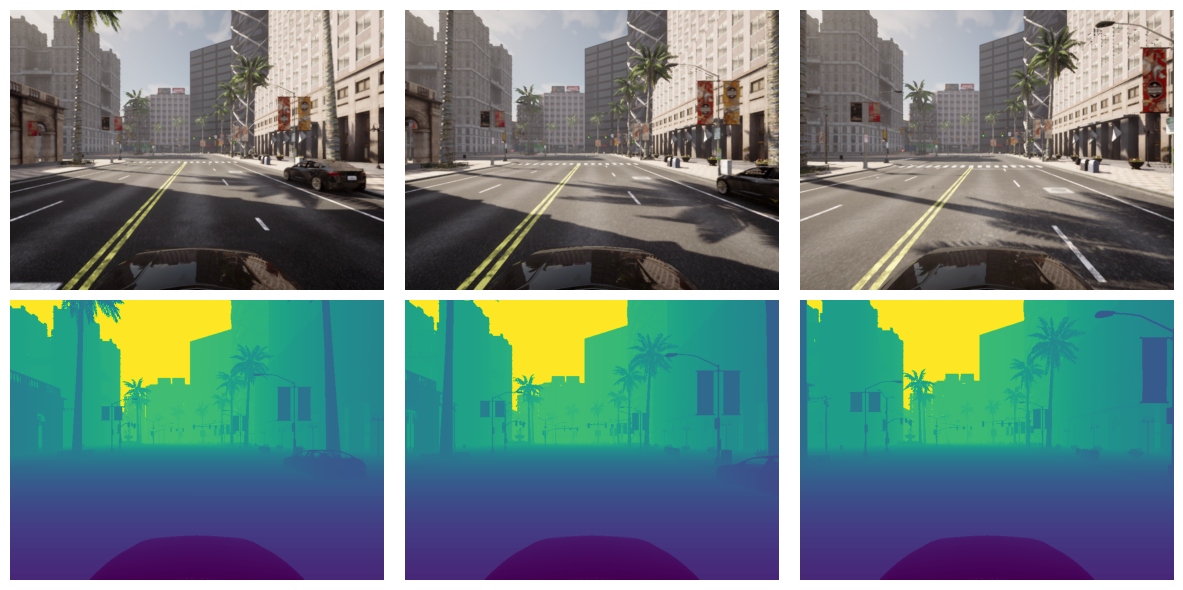

In [7]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax in axs.ravel():
    ax.axis('off')
axs[0, 0].imshow(image_q.permute(1, 2, 0))
axs[0, 1].imshow(image_0.permute(1, 2, 0))
axs[0, 2].imshow(image_1.permute(1, 2, 0))
axs[1, 0].imshow(torch.log(depth_q))
axs[1, 1].imshow(torch.log(depth_0))
axs[1, 2].imshow(torch.log(depth_1))
plt.tight_layout()
plt.show()

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [18]:
def invert_pose(pose):
    R, t = pose
    return R.mT, -(R.mT @ t)

In [19]:
def transform_from_pose(pose):
    R, t = pose
    if len(R.shape) == 2:
        R, t = R.unsqueeze(0), t.unsqueeze(0)
    T = torch.zeros(len(R), 4, 4, device=R.device)
    T[..., :3, :3] = R
    T[..., :3,  3] = t[..., 0]
    T[...,  3,  3] = 1.0
    return T

In [20]:
def pose_from_params(params):
    return roma.rotvec_to_rotmat(params[..., :3]), params[..., 3:, None]

In [21]:
def params_from_pose(pose):
    R, t = pose
    return torch.cat([roma.rotmat_to_rotvec(R), t[..., :, 0]], dim=-1)

In [22]:
transform_from_pose(invert_pose(pose_from_params(params_from_pose((torch.zeros(2, 3, 3), torch.ones(2, 3, 1))))))
# transform_from_params(torch.zeros(6))

tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -8.7423e-08,  1.0000e+00],
         [ 0.0000e+00,  8.7423e-08, -1.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -8.7423e-08,  1.0000e+00],
         [ 0.0000e+00,  8.7423e-08, -1.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

## Perspective Geometry

In [23]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [24]:
def transform(points, pose):
    """
    Project points to camera reference frame
    """
    R, t = pose
    return R @ points + t

In [25]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [26]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [27]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [28]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [29]:
def reproject(depth, image, K, pose):
    """
    Backproject a depth map and transform it into the reference frame of a new camera
    defined by K, R, t by resampling the image.
    """
    points_3d = backproject(depth, K)
    points_3d = transform(points_3d, pose)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output

### Testing Perspective Geometry

Let's see if we can project image_0 into image_1.

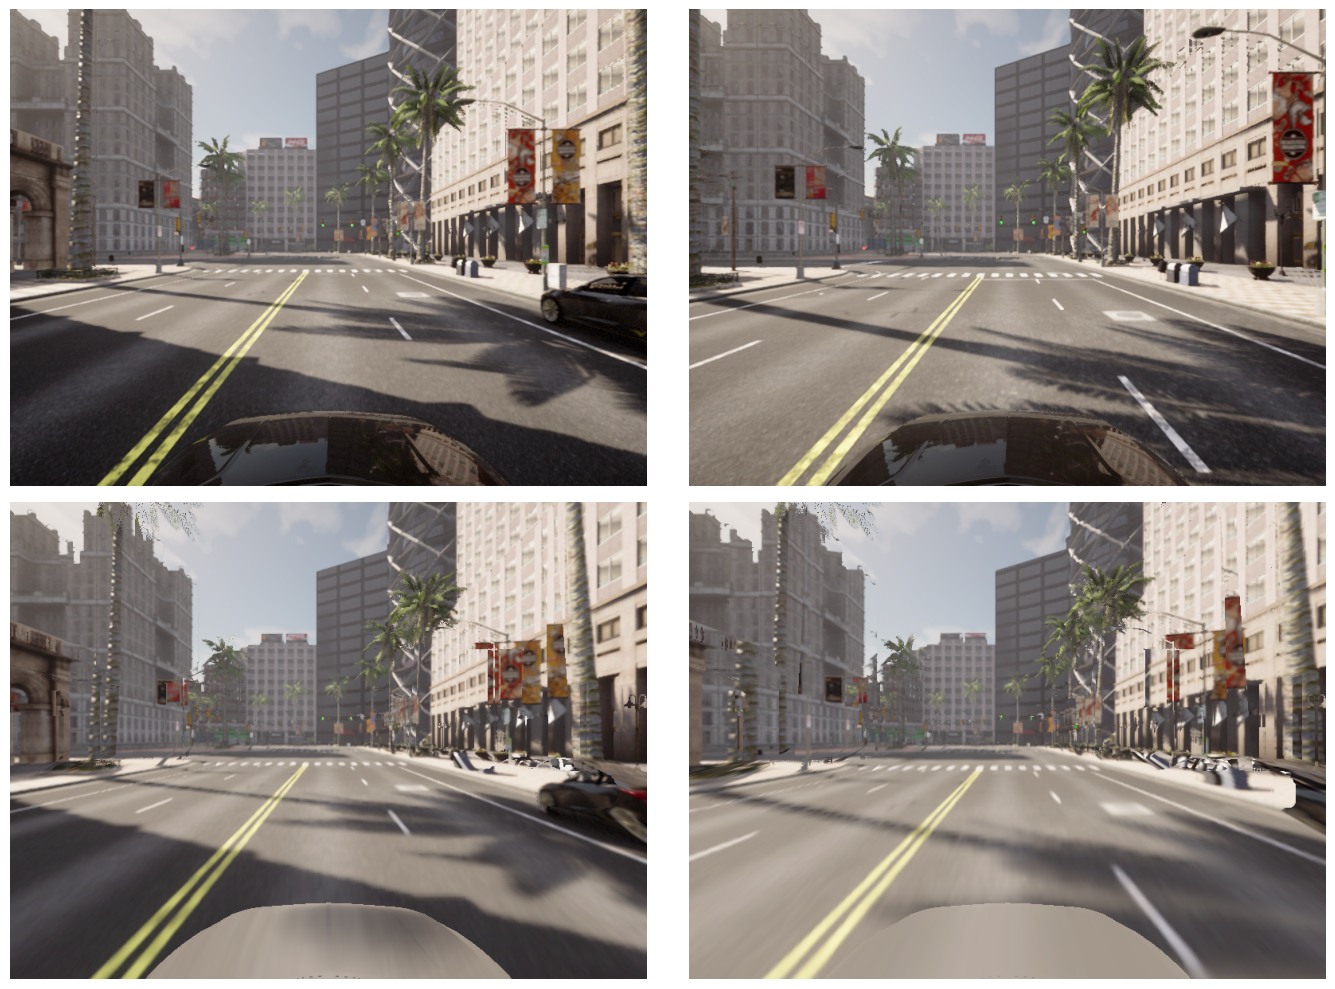

In [20]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]

image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, pose_q0).squeeze()
image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, pose_q1).squeeze()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].imshow(image_0.permute(1,2,0))
axs[0, 1].imshow(image_1.permute(1,2,0))
axs[1, 0].imshow(image_q0.permute(1,2,0))
axs[1, 1].imshow(image_q1.permute(1,2,0))
plt.tight_layout()
plt.show()

## Gauss-Newton

In [30]:
def gauss_newton(x, residuals, damping=1., iterations=5):
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        r = torch.atleast_1d(residuals(x))
        # We need nan_to_num in case there are no errors..!
        J = torch.atleast_2d(torch.autograd.functional.jacobian(residuals, x)).nan_to_num(0)
        # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
        u = torch.linalg.lstsq(J.mT @ J, J.mT @ r).solution
        # Update x, but do nothing if the solution is bad
        x = x - damping * u.nan_to_num(0)
    return x

In [31]:
def gauss_newton_batch(xs, residuals, damping, iterations):
    output = torch.zeros_like(xs)
    for i, x in enumerate(xs):
        output[i] = gauss_newton(x, residuals, damping, iterations)
    return output

In [32]:
def align_feature_maps(K, features_q, saliency_q, features_r, saliency_r, depth_r, gamma):
    def residuals(params):
        pose = pose_from_params(params)
        features_estimated = reproject(depth_r, features_r, K, pose)
        saliency_estimated = reproject(depth_r, saliency_r, K, pose)
        errors = saliency_q * saliency_estimated * huber_norm(features_q - features_estimated, gamma)
        return errors.sum()
    return residuals

## Loss Functions

In [33]:
def huber_norm(x, gamma):
    abs_x = torch.abs(x)
    mask1 = abs_x <= gamma
    mask2 = abs_x > gamma
    mask1 = mask1*0.5*(x**2)
    mask2 = mask2*gamma*(abs_x-gamma/2)
    result = torch.sum(mask1+mask2)
    return result

## Transform Consistency Loss

Looking carefully at the definition of Transform Consistency Loss:

$$
L_{\mathrm{c}}\left(T_{q, r_0}^*, T_{q, r_1}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1}\left(T_{q, r_1}^k\right)^{-1} T_{q, r_0}^*\right)\right\|_1 .
$$

Transform Consistency Loss depends on taking the logarithm of a SE(3) matrix. However, SE(3) matrices have negative numbers that we need to deal with.

To compute the logairthm, we will use the function `se3_log_map` from PyTorch3D. As PyTorch3D is a pain to install, I have just copied the code into `se3.py`.

In [34]:
def transform_consistency_loss(pose_q0, pose_q1, pose_01):
    T_q0 = transform_from_pose(pose_q0)
    T_1q = transform_from_pose(invert_pose(pose_q1))
    T_01 = transform_from_pose(pose_01).to(T_q0.device)

    transform_consistency = T_01 @ T_1q @ T_q0
    return torch.abs(se3_log_map(transform_consistency.mT).mean())

In [35]:
torch.autograd.set_detect_anomaly(False, check_nan=True)

### Test Transform Consistency

In [27]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]
transform_consistency_loss(pose_q0, pose_q1, pose_01)

tensor(6.2685e-06)

## Transform Accuracy Loss

This is essentially a sanity check using ground truth data that we have available.

$$
L_{\mathrm{a}}\left(T_{r_1, r_0}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1} T_{r_1, r_0}^k\right)\right\|_1
$$

In [36]:
def transform_accuracy_loss(pose_est, pose_inv):
    T_est = transform_from_pose(pose_est)
    T_inv = transform_from_pose(pose_inv).to(T_est.device)
    transform_accuracy = T_est @ T_inv
    return torch.abs(se3_log_map(transform_accuracy.mT).mean()) # need to use torch.hubor_loss 

In [30]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]
transform_accuracy_loss(pose_01, invert_pose(pose_01))

tensor(8.1374e-08)

## Data Loader

In [37]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

## Training block

In [38]:
net = UNet(3, 17).to(device)
net.train()

loss_history = []

damping = torch.tensor(0.001, requires_grad=True)

optimizer = torch.optim.Adam([
    {'params': net.parameters(), 'lr': 5e-4},
    {'params': damping, 'lr': 5e-4},
], lr=5e-4)

c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
# let channel = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 =next(iter(dataloader))

pyramid_q = net.forward(image_q.to(device))
pyramid_0 = net.forward(image_0.to(device))
pyramid_1 = net.forward(image_1.to(device))


OutOfMemoryError: CUDA out of memory. Tried to allocate 234.00 MiB (GPU 0; 6.00 GiB total capacity; 4.88 GiB already allocated; 0 bytes free; 5.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
from torch.optim import Adam
epochs = range(0, 1)

# for e in epochs:
    
#     lambd = 1.0 if e == 0 else 1.0 # should be 10 at the first?
    
progress = tqdm.tqdm(dataloader)

for index,batch in enumerate(progress):
    lambd = 10 if index == 0 else 1.0 

    loss = 0
    optimizer.zero_grad()

    # set query image and 2 reference image
    K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = batch
    K = K.to(device)
    pose_10 = invert_pose(pose_01)

    # set inital guess as identity rot-vec. and 0 translation
    result_q0 = torch.zeros(len(K), 6, device=device)
    result_q1 = torch.zeros(len(K), 6, device=device)
    result_01 = torch.zeros(len(K), 6, device=device)

    pyramid_q = net.forward(image_q.to(device))
    pyramid_0 = net.forward(image_0.to(device))
    pyramid_1 = net.forward(image_1.to(device))

    levels = [0, 1, 2, 3]
    iterations = [16, 12, 8, 4]

    for level in levels:
        features_q, saliency_q = pyramid_q[level]
        features_0, saliency_0 = pyramid_0[level]
        features_1, saliency_1 = pyramid_1[level]

        # Resample depth maps for pyramid
        size = features_q.shape[-2:]
        depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)
        depth_1_ = torchvision.transforms.functional.resize(depth_1, size).to(device).unsqueeze(0)

        # Align image_0 to query image
        residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, gamma=0.02)
        result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iterations[level], damping=abs(damping))
        pose_q0_est = pose_from_params(result_q0)

        # Align image_1 to query image
        residuals_q1 = align_feature_maps(K, features_q, saliency_q, features_1, saliency_1, depth_1_, gamma=0.02)
        result_q1 = gauss_newton_batch(result_q1, residuals_q1, iterations=iterations[level], damping=abs(damping))
        pose_q1_est = pose_from_params(result_q1)

        # Compute transform consistency loss
        loss += transform_consistency_loss(pose_q0_est, pose_q1_est, pose_01)
        loss += transform_consistency_loss(pose_q1_est, pose_q0_est, pose_10)

        # Align image_0 to image_1
        residuals_01 = align_feature_maps(K, features_0, saliency_0, features_1, saliency_1, depth_1_, gamma=0.02)
        result_01 = gauss_newton_batch(result_01, residuals_01, iterations=iterations[level], damping=abs(damping))
        pose_01_est = pose_from_params(result_01)

        # Compute transform accuracy loss
        loss += lambd * transform_accuracy_loss(pose_01_est, pose_10)

        if loss.isnan():
            raise ValueError("Loss is NaN!")

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    # with train_summary_writer.as_default():
    #     tf.summary.scalar('loss', loss.item(), step=i)
    #     tf.summary.scalar('l_a', l_a.item(), step=i)
    progress.set_postfix({'loss': loss.item(), 'damping': abs(damping.item()), 'lambda': lambd})


  0%|          | 0/498 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 5.20 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# result_q0 = torch.zeros_like(result_q0)
# residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, gamma=0.02)
# gauss_newton_batch(result_q0, residuals_q0, iterations=13, damping=abs(damping))

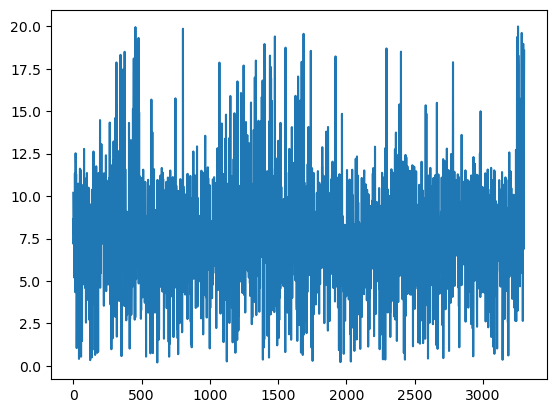

In [41]:
import matplotlib.pyplot as plt

trace = np.array(loss_history)
plt.plot(trace[trace < 20][500:])
plt.show()

In [35]:
torch.save(net.state_dict(),'unet_2.pth')

## Test

Test all the things!